In [2]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion

import sim_template as sim
from importlib import reload 

In [3]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [4]:
#Setup the system:

#For now, use same channel params
nPL = 6.0
kPL = -20

decorrSH = 2.09  
alpha = 30
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.75



#6 remote stations
qBase = np.array([[1,7.5],[14,7.5]])
cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 15
x_min = 0
y_max = 15
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 20
p_th = 0.5
n=1

In [5]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH)





Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


In [6]:
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, region, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)
trismall_pcs = pcs
#%store trismall_pcs
print(prob_pred_con)




Drawing 900 samples from each region
Completed PredictedChannel 1
Completed PredictedChannel 2
[0.8179744525547445]


Extracted edges...
Polygons constructed, looking for holes...
Constructed 4 possibly non-convex polygons
11 total subregions


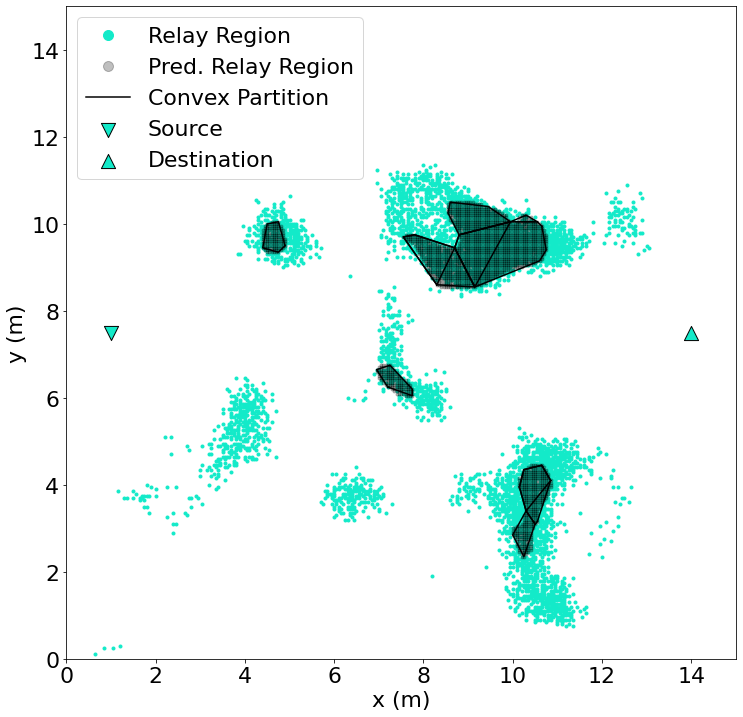

In [7]:
reload(sim)
pointcloud = PC.PointCloud(pjcps[0])
pointcloud.partition(algo=4)
sim.plotDecompFig(n, tjcps, pjcps, qBase, region, pointcloud)
plt.gca().invert_yaxis()
plt.savefig('sim_decomposition_%d_pth_%.2f_gammath_%d.png'%(n, p_th, GAMMA_TH),format='png')
plt.show()

In [8]:
raw_area = len(pjcps[0])*(1/res)**2
print('Original area: %.2f'%(raw_area))

reduced_area = 0
n_cnvx = 0
for poly in pointcloud.polygons:
    reduced_area += poly.area()
    n_cnvx += len(poly.cnvx_partition)
print('Area after reduction: %.2f'%(reduced_area))
print('Number of Convex Polygons in Partition: %d'%(n_cnvx))

Original area: 5.48
Area after reduction: 5.05
Number of Convex Polygons in Partition: 11


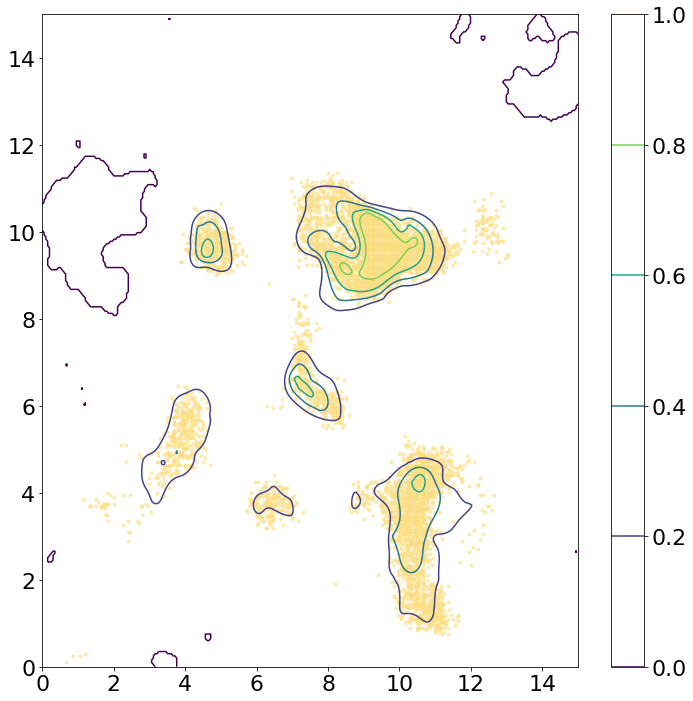

In [37]:
#now also print contous of probability of end to end connectivity
#

for i in range(n):
    Z = pfs[2*i] * pfs[(2*i)+1]
    nx, ny = Z.shape
    X = np.linspace(x_min, x_max, nx)
    Y = np.linspace(y_min, y_max, ny)
    fig = plt.figure(figsize = (12,12))
    pts = tjcps[i]
    plt.plot(pts[:,0], pts[:,1], '.', color='xkcd:wheat', alpha=0.5, zorder=-10)
    C = plt.contour(X, Y, Z.T,[0, 0.2, 0.4, 0.6, 0.8, 1 ])
    fig.colorbar(C)
    plt.show()
    

In [ ]:
###### NOw try with AND rather than * of probabilities over p_th

In [94]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, region, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th, jcm=1)
trismall_pcs = pcs
#%store trismall_pcs
print(prob_pred_con)

pointcloud = PC.PointCloud(pjcps[0])
pointcloud.partition(algo=4)

Drawing 900 samples from each region
Completed PredictedChannel 1
Completed PredictedChannel 2
[0.7953440400766171]
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
20 total subregions


[<pointcloud.Poly at 0x7fd5fc5c96a0>, <pointcloud.Poly at 0x7fd5fc5c9670>]

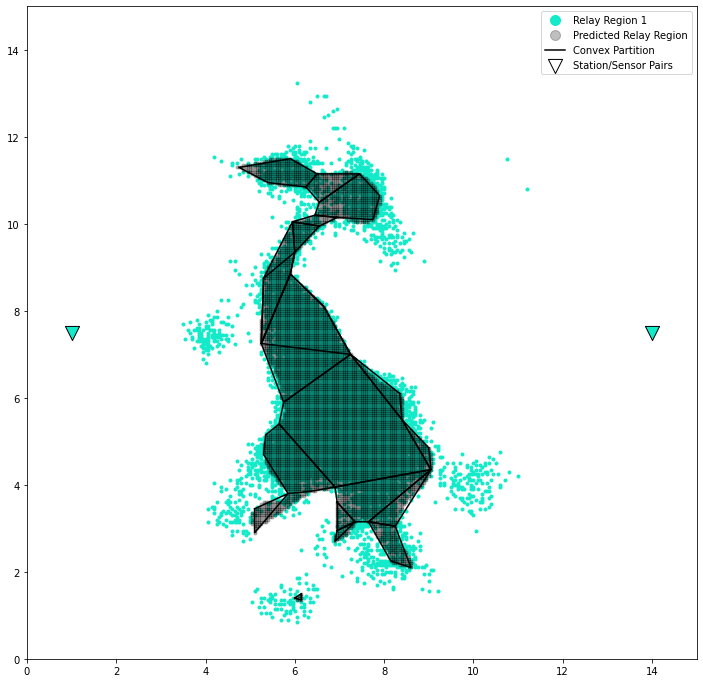

In [95]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
pointcloud.plot_polys()
plt.plot([-100], [-100], '-', color='k', markersize=20, label='Convex Partition')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

In [96]:
raw_area = len(pjcps[0])*(1/res)**2
print('Original area: %.2f'%(raw_area))

reduced_area = 0
n_cnvx = 0
for poly in pointcloud.polygons:
    reduced_area += poly.area()
    n_cnvx += len(poly.cnvx_partition)
print('Area after reduction: %.2f'%(reduced_area))
print('Number of Convex Polygons in Partition: %d'%(n_cnvx))

Original area: 16.97
Area after reduction: 16.57
Number of Convex Polygons in Partition: 20


In [1]:
prob_pred_con

NameError: name 'prob_pred_con' is not defined